This notebook runs tracking with a ground truth file, and determines the best confidence threshold for the model to reduce the number of switches while mainitaining maximum prediction density (i.e. don't throw too many predictions out)

In [ ]:
import h5py
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from dreem.inference import eval
from omegaconf import OmegaConf

### Specify the path to a tracking configuration file
#### The files you run tracking on must have ground truth identities so they can be evaluated

In [ ]:
config = "/path/to/eval-config.yaml"
cfg = OmegaConf.load(config)

### Run eval
This runs tracking, evaluates compared to ground truth labels, and saves some metadata that we will use later on

In [ ]:
cfg["save_frame_meta"] = True  # we need extra metadata to find the threshold
cfg["confidence_threshold"] = None  # we're going to find the best threshold
eval.run(cfg)

### Now read in the saved results and metadata

In [35]:
h5_path = cfg["outdir"]
h5_files = [os.path.join(h5_path, f) for f in os.listdir(h5_path) if f.endswith(".h5")]
h5_files

['/root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/four_flies_eval_save_meta/four_flies@1000-11000_sample_0_3465_4965.dreem_metrics.h5',
 '/root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/four_flies_eval_save_meta/four_flies@1000-11000_sample_0_3465_4965_1.dreem_metrics.h5',
 '/root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/four_flies_eval_save_meta/four_flies@1000-11000_sample_0_3465_4965_2.dreem_metrics.h5',
 '/root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/four_flies_eval_save_meta/four_flies@1000-11000_sample_0_3465_4965_3.dreem_metrics.h5',
 '/root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/four_flies_eval_save_meta/four_flies@1000-11000_sample_0_8397_9897.dreem_metrics.h5']

In [ ]:
# select 1 h5 file; choose whichever one you want
h5_file = h5_files[0]

In [59]:
switch_frames = []
dict_all_association_matrices = {}
with h5py.File(h5_file, "r") as results_file:
    for vid_name in results_file.keys():
        vid_group = results_file[vid_name]
        mot_summary = vid_group["mot_summary"]
        print("Number of switches: ", mot_summary.attrs["num_switches"])
        frame_meta_group = vid_group["frame_meta"]
        switch_group = frame_meta_group["switches"]
        for frame in frame_meta_group.keys():
            if "traj_scores" not in frame_meta_group[frame].keys():
                continue
            if "final" in frame_meta_group[frame]["traj_scores"].keys():
                dict_all_association_matrices[frame.replace("frame_", "")] = (
                    frame_meta_group[frame]["traj_scores"]["final"][:]
                )
            else:
                print(f"No final association matrix found for frame {frame}")
        for frame in switch_group.attrs:
            if switch_group.attrs[frame]:
                switch_frames.append(int(frame.replace("frame_", "")))

Number of switches:  8.0
No final association matrix found for frame frame_0


In [51]:
switch_frames

[874, 875, 877, 878]

#### Analyze the association matrix for a switch frame to see how confident or unconfident the mode is about its predictions
We will use the entropy of each row of theassociation matrix as a measure of confidence

In [52]:
def softmax(x):
    e_x = np.exp(x - np.max(x, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

In [88]:
switch_frame_entropies = []
non_switch_frame_entropies = []
non_switch_frame_entropies_ix = []
switch_frame_entropies_ix = []
max_num_instances = 0
for i, (k, v) in enumerate(dict_all_association_matrices.items()):
    if i % 5000 == 0:
        print(f"Processing frame {i} of {len(dict_all_association_matrices)}")
    # Apply softmax to each row of the association matrix
    softmaxed_asso = softmax(v)
    # Compute entropy for each row
    entropy = -np.sum(softmaxed_asso * np.log(softmaxed_asso + 1e-12), axis=1)
    mean_entropy = np.mean(entropy)
    std_entropy = np.std(entropy)
    num_instances = v.shape[0]
    if num_instances > max_num_instances:
        max_num_instances = num_instances
    normalized_entropy = mean_entropy / np.log(num_instances)
    # print(f"Entropy per row: {entropy}, Mean entropy: {mean_entropy}, Std deviation of entropy: {std_entropy}")
    if int(k) in switch_frames:
        switch_frame_entropies.append(normalized_entropy)
        switch_frame_entropies_ix.append(k)
    else:
        non_switch_frame_entropies.append(normalized_entropy)
        non_switch_frame_entropies_ix.append(k)
arr_sw_frame_confidences = 100 * (1 - np.array(switch_frame_entropies))
arr_non_sw_frame_confidences = 100 * (1 - np.array(non_switch_frame_entropies))
arr_non_sw_frame_confidences_ix = np.array(non_switch_frame_entropies_ix)
pct_99 = np.percentile(arr_non_sw_frame_confidences, 99) / np.log(max_num_instances)

Processing frame 0 of 1499


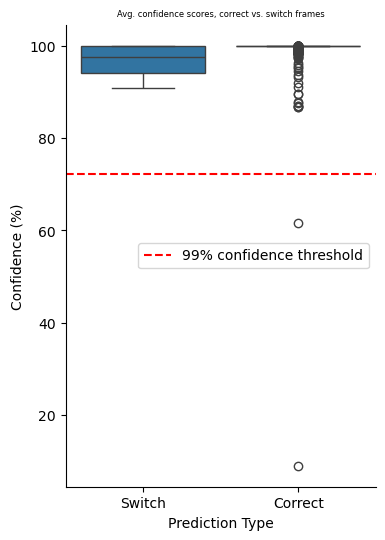

In [ ]:
plt.figure(figsize=(4, 6))

# Create a DataFrame for side-by-side boxplot
df_entropy = pd.DataFrame(
    {
        "Confidence": np.concatenate(
            [arr_sw_frame_confidences, arr_non_sw_frame_confidences]
        ),
        "Frame Type": (["Switch"] * len(arr_sw_frame_confidences))
        + (["Correct"] * len(arr_non_sw_frame_confidences)),
    }
)
plt.axhline(y=pct_99, color="r", linestyle="--", label="99% confidence threshold")
sns.boxplot(x="Frame Type", y="Confidence", data=df_entropy)
plt.ylabel("Confidence (%)")
plt.xlabel("Prediction Type")
plt.title(f"Avg. confidence scores, correct vs. switch frames", fontsize=6)
sns.despine()
plt.show()

#### If the above confidence threshold looks good, we can run tracking again with the new threshold. If not, you can select your own confidence threshold. Note that the confidence scores of correct vs.switch frames should be different, and the threshold should ideally be below most correct frame confidences and above most switch frame confidences.

In [ ]:
confidence_threshold = pct_99 / 100  # or enter your own threshold
cfg["save_frame_meta"] = False  # we don't need to save extra metadata this time
cfg["confidence_threshold"] = confidence_threshold
eval.run(
    cfg
)  # will save to the same directory as the first run, with a more recent timestamp

Using the following tracker:
Tracker(max_tracks=10, use_vis_feats=True, overlap_thresh=0.01, mult_thresh=True, decay_time=None, max_center_dist=200, verbose=False, queue=TrackQueue(window_size=8, max_gap=inf, n_tracks=0, queues=[], curr_gap:{}), temperature=0.1
Computing the following metrics:
all
Saving tracking results and metrics to /root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/results-keypt-dilate-optimal-threshold
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/root/miniforge3/envs/dreem/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, 

Testing: |          | 0/? [00:00<?, ?it/s]

Saving metrics to /root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/results-keypt-dilate-optimal-threshold/train_labels.group1.centroids_sample_1_17032_18532.dreem_metrics.h5
Saving inference results to /root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/results-keypt-dilate-optimal-threshold/train_labels.group1.centroids_sample_1_17032_18532.dreem_inference.10-21-2025-18-42-12.slp


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    11.469264030456543     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/root/miniforge3/envs/dreem/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

Saving metrics to /root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/results-keypt-dilate-optimal-threshold/train_labels.group1.centroids_sample_1_6952_8452.dreem_metrics.h5
Saving inference results to /root/vast/mustafa/dreem-experiments/run/dev/threshold-preds/results-keypt-dilate-optimal-threshold/train_labels.group1.centroids_sample_1_6952_8452.dreem_inference.10-21-2025-18-52-21.slp


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    11.795063972473145     │
└───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/root/miniforge3/envs/dreem/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=63` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


SystemExit: 1

/root/miniforge3/envs/dreem/lib/python3.12/site-packages/IPython/core/interactiveshell.py:3707: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)
